In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

true_bias = -15
features, target, true_weights = make_regression(n_features=5,
                coef=True,
                n_informative=3,
                bias=true_bias,
                n_samples=30000,
                random_state=42,
                )

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, shuffle=True, random_state=42)

In [28]:
class CustomLinearRegression:
    def __init__(self, number_of_iterations=1000, learning_rate=0.1,
                regularize=False, regularization_strength=1, regularization_type='l2',
                verbose=False, log_every=100, early_stop=False, tolerance=0.001):
        self.weights : np.ndarray = None  # (n_features, )
        self.bias : float = None  # scalar 
        
        self.number_of_iterations : int = number_of_iterations
        self.learning_rate : float = learning_rate
        
        self.cost_history : list[float] = []
        
        self.regularize = regularize
        self.regularization_strength = regularization_strength
        self.regularization_type = regularization_type
        
        self.verbose = verbose
        self.log_every = log_every

        self.early_stop = early_stop
        self.tolerance = tolerance

    # ---------------------------------------------------------------------------------------------------------
    
    def _compute_loss(self, true_values, predicted_values) -> float:
    # the difference between the the true values (y) and the predicted values (y_hat)
        errors = true_values - predicted_values
        
        squared_errors = np.square(errors)  # square the errors
        mean_squared_error = np.mean(squared_errors)  # sum the squared error then divide by number of samples
    
        # if user chooses to regularize
        if self.regularize and self.regularization_type == 'l2':
            # number of samples
            m = true_values.shape[0]
            
            weights_squared = np.square(self.weights)
            sum_weights_squared = np.sum(weights_squared)
            
            l2_penalty = (self.regularization_strength / m) * sum_weights_squared
            return 1/2 * (mean_squared_error + l2_penalty)
    
        elif self.regularize and self.regularization_type == 'l1':
            m = true_values.shape[0]
            
            weights_absolute_values = np.abs(self.weights)
            sum_absolute_values = np.sum(weights_absolute_values)
            
            l1_penalty = (self.regularization_strength / m) * sum_absolute_values
            return 1/2 * (mean_squared_error + l1_penalty)
            
        # if user does not choose to regularize
        else:
            return 1/2 * mean_squared_error

    # ---------------------------------------------------------------------------------------------------------
    
    def _forward_propagation(self, input_matrix, true_values):
        y_hat = input_matrix @ self.weights + self.bias  # predictions of the model using current weights and bias
        cost = self._compute_loss(true_values, y_hat)    # cost of the current predictions and the true values 
        self.cost_history.append(cost)                   # add the current cost the list of costs 
        return y_hat                                     # return the current predictions and the current cost

    # ---------------------------------------------------------------------------------------------------------
    
    def _backward_propagation(self, feature_matrix, true_values, predicted_values):
        number_of_samples = feature_matrix.shape[0]
        error = predicted_values - true_values
    
        # notice that bias is not regularized (no l1 or l2 terms)
        bias_derivative = np.mean(error)
    
        # weights gradient without regulariztion
        unregularized_weights_gradient = 1 / number_of_samples * (feature_matrix.T @ error)
    
        # add L2 regularization if enabled
        if self.regularize and self.regularization_type == 'l2':
            l2_penalty = (self.regularization_strength / number_of_samples) * self.weights
            weights_gradient = unregularized_weights_gradient + l2_penalty
            return weights_gradient, bias_derivative

        # add L1 regularization if enable
        elif self.regularize and self.regularization_type == 'l1':
            l1_penalty = (self.regularization_strength / number_of_samples) * np.sign(self.weights)
            weights_gradient = unregularized_weights_gradient + l1_penalty
            return weights_gradient, bias_derivative
            
        # without any regularization
        else:
            # note that weights_gradient == unregularized_term if no regularization is applied
            weights_gradient = unregularized_weights_gradient
            return weights_gradient, bias_derivative

    # ---------------------------------------------------------------------------------------------------------
    
    def _update(self, weights_gradient, bias_derivative):
        if self.regularize and self.regularization_type == 'l1':
            # Gradient descent step without regularization term included, 
            # because regularization is handled by proximal step below
            temp_weights = self.weights - (self.learning_rate * weights_gradient)
            # Soft-thresholding (proximal operator)
            threshold = self.learning_rate * self.regularization_strength / len(temp_weights)  # or number_of_samples
            
            self.weights = np.sign(temp_weights) * np.maximum(np.abs(temp_weights) - threshold, 0)
            self.bias = self.bias - (self.learning_rate * bias_derivative)
        else:
            self.weights = self.weights - (self.learning_rate * weights_gradient)
            self.bias = self.bias - (self.learning_rate * bias_derivative)

    # ---------------------------------------------------------------------------------------------------------
    
    def _init_parameters(self, n_features):
        self.weights = np.random.normal(0.0, 0.01, size=n_features)
        self.bias = 0

    # ---------------------------------------------------------------------------------------------------------
    
    def fit(self, X, y):
        self._init_parameters(X.shape[1])

        for iteration in range(self.number_of_iterations):
            y_hat = self._forward_propagation(X, y)
            weights_derivative, bias_derivative = self._backward_propagation(X, y, y_hat)
            self._update(weights_derivative, bias_derivative)

            if self.verbose and (iteration % self.log_every == 0 or iteration == self.number_of_iterations - 1):
                print(f'Iteration: {iteration} | Cost: {self.cost_history[iteration]} | Weights Norm: {np.linalg.norm(self.weights):.2f}')

            if self.early_stop and iteration >= 2 and np.abs(self.cost_history[-1] - self.cost_history[-2]) <= self.tolerance:
                print(f'Early stoppage at iteration: {iteration} | difference in cost is less than {self.tolerance}')
                break


        return self

    # ---------------------------------------------------------------------------------------------------------
    
    def predict(self, X):
        predictions = X @ self.weights + self.bias
        return predictions

    # ---------------------------------------------------------------------------------------------------------
    
    def plot_losses(self, ax=None):
        if ax is None:
            ax = plt.gca()
        
        sns.lineplot(self.cost_history, label=f'Final cost: {self.cost_history[-1]:.5f}', ax=ax)
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Cost')
        ax.set_title('Training Cost Vs Iteration')
        ax.grid()
        ax.legend()

<hr color='red'>
<hr color='blue'>


In [29]:
from sklearn.datasets import load_diabetes

data = load_diabetes()

features = data.data
target = data.target

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, shuffle=True, random_state=42)

In [30]:
lr = CustomLinearRegression(verbose=True,
                            log_every=100,
                            number_of_iterations=1000,
                            learning_rate=0.1,
                            regularize=True,
                            regularization_strength=0.1,
                            early_stop=True,
                            tolerance=0.001).fit(X_train, y_train)
predictions = lr.predict(X_test)

Iteration: 0 | Cost: 14933.393959389921 | Weights Norm: 0.51
Iteration: 100 | Cost: 2842.9358989873763 | Weights Norm: 43.07
Iteration: 200 | Cost: 2692.555483810146 | Weights Norm: 81.81
Iteration: 300 | Cost: 2564.0848207362833 | Weights Norm: 117.60
Iteration: 400 | Cost: 2454.0210065289184 | Weights Norm: 150.71
Iteration: 500 | Cost: 2359.441246653952 | Weights Norm: 181.37
Iteration: 600 | Cost: 2277.905550930393 | Weights Norm: 209.81
Iteration: 700 | Cost: 2207.3758312267187 | Weights Norm: 236.22
Iteration: 800 | Cost: 2146.1486259597928 | Weights Norm: 260.77
Iteration: 900 | Cost: 2092.799151820504 | Weights Norm: 283.64
Iteration: 999 | Cost: 2046.5717483812598 | Weights Norm: 304.75


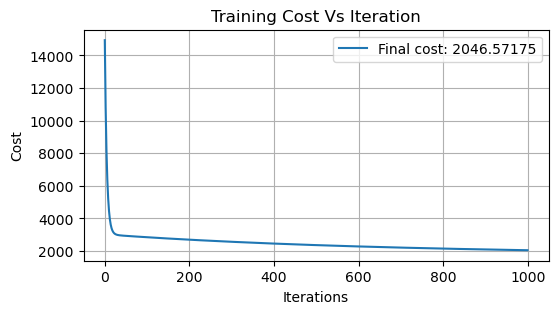

In [31]:
plt.figure(figsize=(6, 3))
lr.plot_losses()